# Analyse CIGALE Results for EMU sources

In [7]:
observatory = '/data/mfonseca/'
my_computer = '/home/polaris/Lab_Astro/data/'

directory = my_computer

## Import Libraries

In [8]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import numpy as np
import pandas as pd

import math

# Astropy
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.cosmology import Planck18 as cosmo

# CuPY
# import cupy as cp

# Seaborn
import seaborn as sns

In [9]:
catalog_path = '/home/polaris/Lab_Astro/data/cigale/all_data_6/out7/EMU_0102-32_DESY6GOLD_VIKINGDR5_CATWISE_noMag_CIGALE.fits'
catalog_table = Table.read(catalog_path)
catalog_pd = catalog_table.to_pandas()

# Calculate log10 of parameters
catalog_pd['log_stellar_mass'] = np.log10(catalog_pd['bayes.stellar.m_star'])
catalog_pd['log_sfr'] = np.log10(catalog_pd['bayes.sfh.sfr'])
catalog_pd['log_sfr_permass'] = np.log10(catalog_pd['bayes.sfh.sfr'] / catalog_pd['bayes.stellar.m_star'])
catalog_pd['log_metallicity'] = np.log10(catalog_pd['bayes.stellar.metallicity'])
catalog_pd['log_age'] = np.log10(catalog_pd['bayes.sfh.age'])
catalog_pd['log_Av_BC'] = np.log10(catalog_pd['bayes.attenuation.Av_BC'])

# Propagate errors for logs: Δ(log10 x) = Δx / (x * ln(10))
catalog_pd['log_stellar_mass_err'] = catalog_pd['bayes.stellar.m_star_err'] / (catalog_pd['bayes.stellar.m_star'] * np.log(10))
catalog_pd['log_sfr_err'] = catalog_pd['bayes.sfh.sfr_err'] / (catalog_pd['bayes.sfh.sfr'] * np.log(10))
catalog_pd['log_sfr_permass_err'] = np.sqrt(
    (catalog_pd['bayes.sfh.sfr_err'] / (catalog_pd['bayes.sfh.sfr'] * np.log(10)))**2 +
    (catalog_pd['bayes.stellar.m_star_err'] / (catalog_pd['bayes.stellar.m_star'] * np.log(10)))**2
)
catalog_pd['log_metallicity_err'] = catalog_pd['bayes.stellar.metallicity_err'] / (catalog_pd['bayes.stellar.metallicity'] * np.log(10))
catalog_pd['log_age_err'] = catalog_pd['bayes.sfh.age_err'] / (catalog_pd['bayes.sfh.age'] * np.log(10))
catalog_pd['log_Av_BC_err'] = catalog_pd['bayes.attenuation.Av_BC_err'] / (catalog_pd['bayes.attenuation.Av_BC'] * np.log(10))

print(catalog_pd.columns.tolist())


['EMU_island_id', 'EMU_island_name', 'EMU_n_components', 'EMU_ra_deg_cont', 'EMU_dec_deg_cont', 'EMU_freq', 'EMU_maj_axis', 'EMU_min_axis', 'EMU_pos_ang', 'EMU_flux_int', 'EMU_flux_int_err', 'EMU_flux_peak', 'EMU_mean_background', 'EMU_background_noise', 'EMU_max_residual', 'EMU_min_residual', 'EMU_mean_residual', 'EMU_rms_residual', 'EMU_stdev_residual', 'EMU_x_min', 'EMU_x_max', 'EMU_y_min', 'EMU_y_max', 'EMU_n_pix', 'EMU_solid_angle', 'EMU_beam_area', 'EMU_x_ave', 'EMU_y_ave', 'EMU_x_cen', 'EMU_y_cen', 'EMU_x_peak', 'EMU_y_peak', 'EMU_flag_i1', 'EMU_flag_i2', 'EMU_flag_i3', 'EMU_flag_i4', 'DESY6_coadd_object_id', 'DESY6_ra', 'DESY6_dec', 'DESY6_mag_auto_g', 'DESY6_magerr_auto_g', 'DESY6_mag_auto_r', 'DESY6_magerr_auto_r', 'DESY6_mag_auto_i', 'DESY6_magerr_auto_i', 'DESY6_mag_auto_z', 'DESY6_magerr_auto_z', 'DESY6_mag_auto_y', 'DESY6_magerr_auto_y', 'DESY6_a_fiducial_g', 'DESY6_a_fiducial_i', 'DESY6_a_fiducial_r', 'DESY6_a_fiducial_y', 'DESY6_a_fiducial_z', 'DESY6_spread_model_g', 'D

## Average and error of the results

In [19]:
max_row = catalog_pd.loc[catalog_pd['bayes.agn.fracAGN'].idxmax()]
print(max_row)

EMU_island_id          b'  SB53293_island_6996'
EMU_island_name               b'J011418-341249'
EMU_n_components                              1
EMU_ra_deg_cont                       18.577163
EMU_dec_deg_cont                     -34.213659
                                 ...           
log_sfr_err                            0.169968
log_sfr_permass_err                    0.221631
log_metallicity_err                    0.188151
log_age_err                            0.203146
log_Av_BC_err                           0.00001
Name: 2897, Length: 374, dtype: object


# Histogram of all results

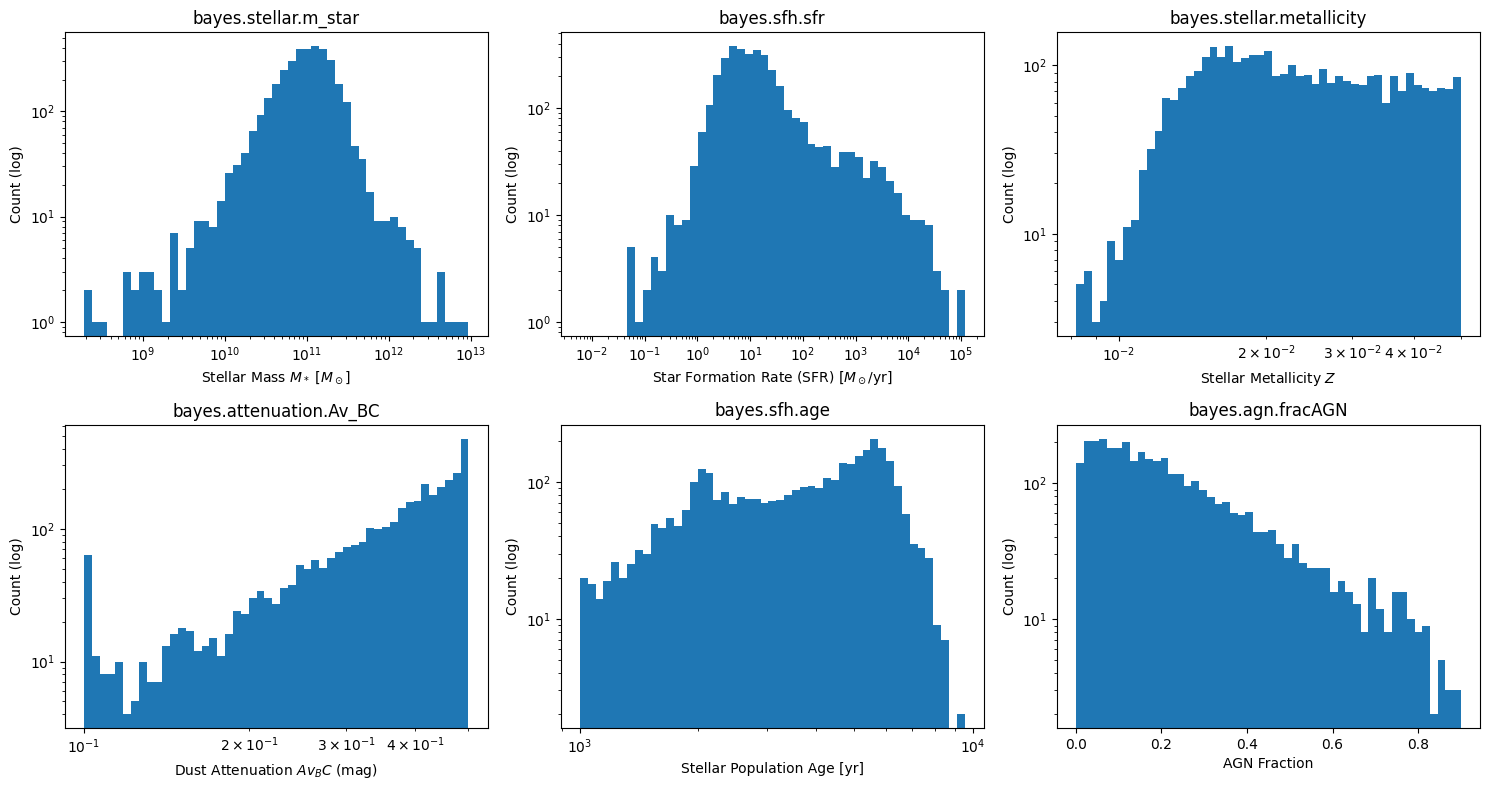

In [10]:
def plot_log_histograms_2rows_hist(df, columns, x_labels, figsize=(15, 8)):
    """
    Plot histograms (using .hist()) of specified DataFrame columns in 2 rows,
    with log-log scaling on both axes except for specific exceptions.

    Parameters:
    - df: pandas DataFrame
    - columns: list of column names to plot
    - x_labels: list of x-axis labels (same length as columns)
    - figsize: figure size (width, height)
    """
    n = len(columns)
    nrows = 2
    ncols = math.ceil(n / nrows)

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)

    for i, col in enumerate(columns):
        row = i // ncols
        col_idx = i % ncols
        ax = axes[row, col_idx]

        data = df[col].dropna()

        # Identify whether to use log x-axis
        if 'bayes.agn.fracAGN' in col:
            # Linear x-axis bins
            bins = 50
            ax.hist(data, bins=bins)
            ax.set_yscale('log')  # Still use log y
        else:
            data = data[data > 0]  # log scale requires strictly positive values
            bins = np.logspace(np.log10(data.min()), np.log10(data.max()), 50)
            ax.hist(data, bins=bins)
            ax.set_xscale('log')
            ax.set_yscale('log')

        ax.set_title(col)
        ax.set_xlabel(x_labels[i])
        ax.set_ylabel('Count (log)')

    # Hide any unused subplots
    total_plots = nrows * ncols
    for j in range(n, total_plots):
        row = j // ncols
        col_idx = j % ncols
        axes[row, col_idx].axis('off')

    plt.tight_layout()
    plt.show()

x_labels = [
    r"Stellar Mass $M_*$ [$M_\odot$]",
    r"Star Formation Rate (SFR) [$M_\odot$/yr]",
    r"Stellar Metallicity $Z$",
    r"Dust Attenuation $Av_BC$ (mag)",
    r"Stellar Population Age [yr]",
    r"AGN Fraction"
]

# Example usage:
plot_log_histograms_2rows_hist(catalog_pd , ['bayes.stellar.m_star', 'bayes.sfh.sfr', 'bayes.stellar.metallicity','bayes.attenuation.Av_BC','bayes.sfh.age' ,'bayes.agn.fracAGN'], x_labels)


# Interesting plots

## AGN fraction vs Stellar Mass , colored by redshift

In [11]:
# # Compute log stellar mass and its error
# catalog_pd['log_stellar_mass'] = np.log10(catalog_pd['bayes.stellar.m_star'])


# # Create the JointGrid
# g = sns.JointGrid(
#     data=catalog_pd,
#     x='bayes.agn.fracAGN',
#     y='log_stellar_mass',
#     height=8
# )

# # Plot with error bars
# points = g.ax_joint.errorbar(
#     catalog_pd['bayes.agn.fracAGN'],
#     catalog_pd['log_stellar_mass'],
#     yerr=catalog_pd.get('log_stellar_mass_err', None),  # replace with actual error column
#     xerr=catalog_pd.get('agn_frac_err', None),          # optional: error in AGN fraction
#     fmt='o',
#     c=catalog_pd['bayes.universe.redshift'],
#     cmap='viridis',
#     alpha=0.7,
#     markersize=4,
#     linestyle='none'
# )

# # Add marginal histograms
# sns.histplot(data=catalog_pd, x='bayes.agn.fracAGN', bins=40, ax=g.ax_marg_x, color='grey', edgecolor='black')
# sns.histplot(data=catalog_pd, y='log_stellar_mass', bins=40, ax=g.ax_marg_y, color='grey', edgecolor='black')

# # Axis labels and title
# g.set_axis_labels('AGN Fraction', r'$\log_{10}(M_*/M_\odot)$')
# g.fig.suptitle('AGN Fraction vs Stellar Mass (with Error Bars, colored by Redshift)', fontsize=16)
# g.fig.subplots_adjust(top=0.95, right=0.85)

# # Add colorbar outside the plot
# cbar_ax = g.fig.add_axes([0.87, 0.3, 0.02, 0.4])
# g.fig.colorbar(points, cax=cbar_ax, label='Redshift')

# plt.show()


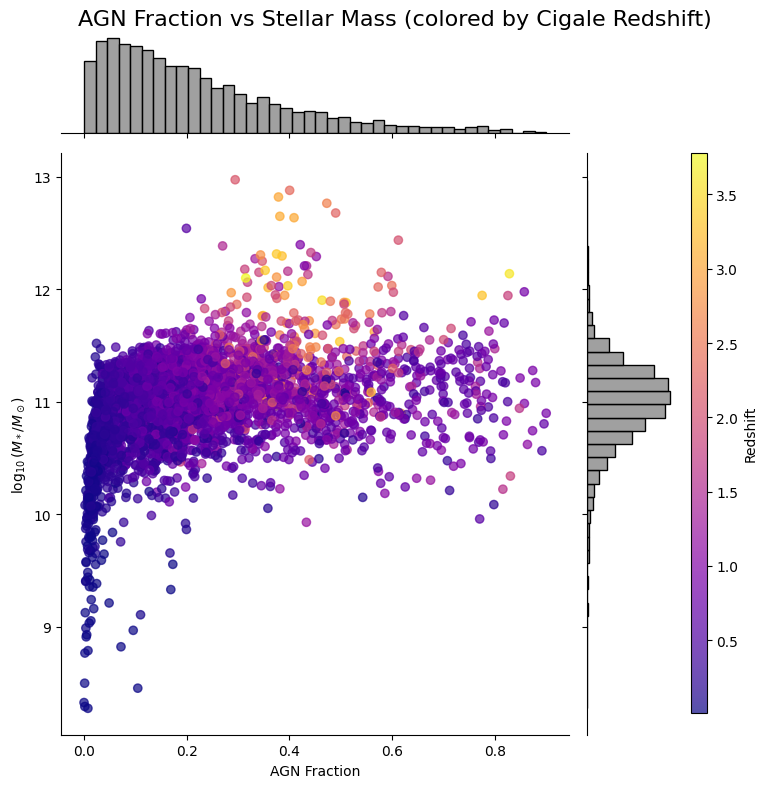

In [12]:
# Compute log stellar mass
catalog_pd['log_stellar_mass'] = np.log10(catalog_pd['bayes.stellar.m_star'])

# Create the JointGrid
g = sns.JointGrid(
    data=catalog_pd,
    x='bayes.agn.fracAGN',
    y='log_stellar_mass',
    height=8
)

# Main scatterplot with color by redshift
points = g.ax_joint.scatter(
    catalog_pd['bayes.agn.fracAGN'],
    catalog_pd['log_stellar_mass'],
    c=catalog_pd['bayes.universe.redshift'],
    cmap='plasma',
    alpha=0.7
)

# Add marginal histograms
sns.histplot(
    data=catalog_pd,
    x='bayes.agn.fracAGN',
    bins=40,
    ax=g.ax_marg_x,
    color='grey',
    edgecolor='black'
)
sns.histplot(
    data=catalog_pd,
    y='log_stellar_mass',
    bins=40,
    ax=g.ax_marg_y,
    color='grey',
    edgecolor='black'
)

# Set axis labels and title
g.set_axis_labels('AGN Fraction', r'$\log_{10}(M_*/M_\odot)$')
g.fig.suptitle('AGN Fraction vs Stellar Mass (colored by Cigale Redshift)', fontsize=16)
g.fig.subplots_adjust(top=0.95, right=0.85)  # Shrink plot area to make room for colorbar

# Add external colorbar
cbar_ax = g.fig.add_axes([0.87, 0.1, 0.02, 0.7])  # [left, bottom, width, height]
g.fig.colorbar(points, cax=cbar_ax, label='Redshift')

plt.show()


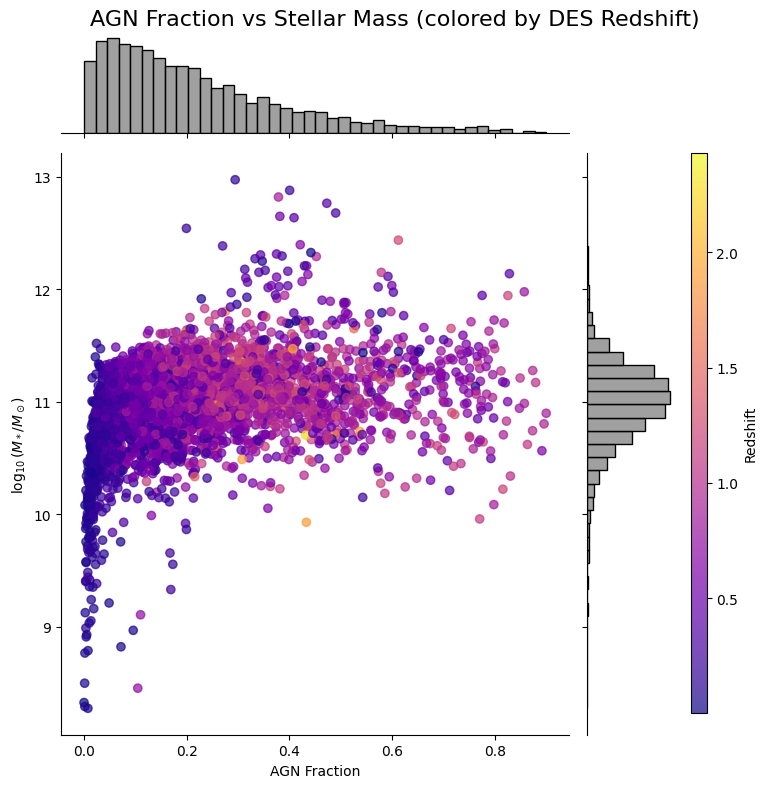

In [13]:
# Compute log stellar mass
catalog_pd['log_stellar_mass'] = np.log10(catalog_pd['bayes.stellar.m_star'])

# Create the JointGrid
g = sns.JointGrid(
    data=catalog_pd,
    x='bayes.agn.fracAGN',
    y='log_stellar_mass',
    height=8
)

# Main scatterplot with color by redshift
points = g.ax_joint.scatter(
    catalog_pd['bayes.agn.fracAGN'],
    catalog_pd['log_stellar_mass'],
    c=catalog_pd['DESY6_dnf_z'],
    cmap='plasma',
    alpha=0.7
)

# Add marginal histograms
sns.histplot(
    data=catalog_pd,
    x='bayes.agn.fracAGN',
    bins=40,
    ax=g.ax_marg_x,
    color='grey',
    edgecolor='black'
)
sns.histplot(
    data=catalog_pd,
    y='log_stellar_mass',
    bins=40,
    ax=g.ax_marg_y,
    color='grey',
    edgecolor='black'
)

# Set axis labels and title
g.set_axis_labels('AGN Fraction', r'$\log_{10}(M_*/M_\odot)$')
g.fig.suptitle('AGN Fraction vs Stellar Mass (colored by DES Redshift)', fontsize=16)
g.fig.subplots_adjust(top=0.95, right=0.85)  # Shrink plot area to make room for colorbar

# Add external colorbar
cbar_ax = g.fig.add_axes([0.87, 0.1, 0.02, 0.7])  # [left, bottom, width, height]
g.fig.colorbar(points, cax=cbar_ax, label='Redshift')

plt.show()

## SFR vs Stellar Mass , colored by redshift

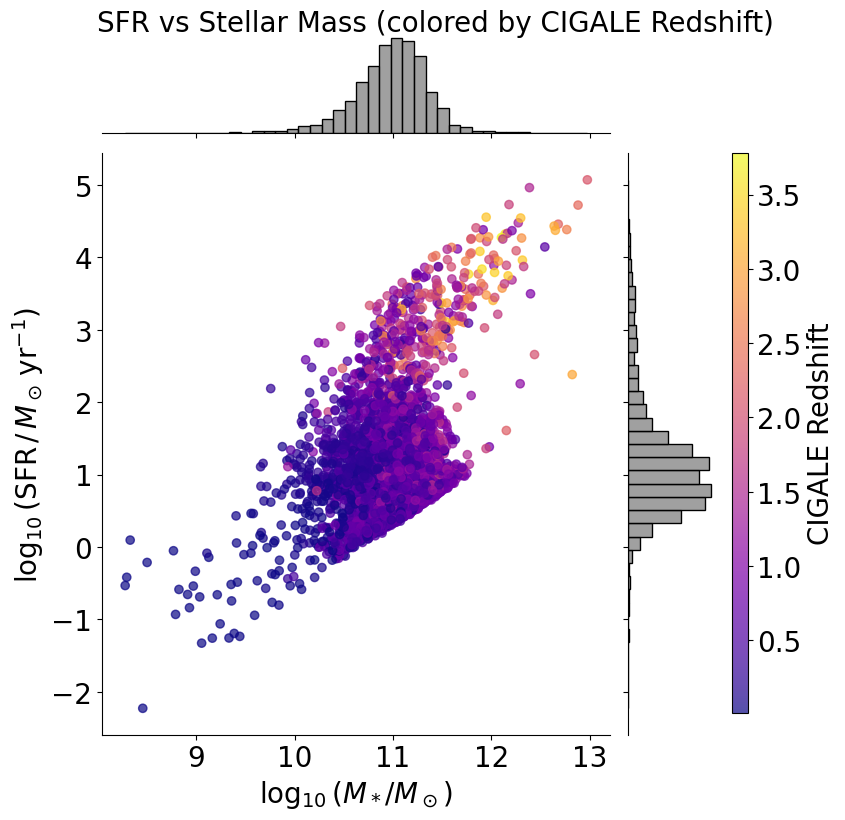

In [24]:
# Create the JointGrid
g = sns.JointGrid(
    data=catalog_pd,
    x='log_stellar_mass',
    y='log_sfr',
    height=8
)

# Main scatterplot with color by redshift
points = g.ax_joint.scatter(
    catalog_pd['log_stellar_mass'],
    catalog_pd['log_sfr'],
    c=catalog_pd['bayes.universe.redshift'],
    cmap='plasma',
    alpha=0.7
)

# Add marginal histograms
sns.histplot(
    data=catalog_pd,
    x='log_stellar_mass',
    bins=40,
    ax=g.ax_marg_x,
    color='grey',
    edgecolor='black'
)
sns.histplot(
    data=catalog_pd,
    y='log_sfr',
    bins=40,
    ax=g.ax_marg_y,
    color='grey',
    edgecolor='black'
)

# Set axis labels and title with larger font
g.set_axis_labels(
    r'$\log_{10}(M_*/M_\odot)$',
    r'$\log_{10}({\rm SFR}\,/\,M_\odot\,{\rm yr}^{-1})$',
    fontsize=20
)
g.ax_joint.tick_params(axis='both', labelsize=20)
g.ax_marg_x.tick_params(labelsize=20)
g.ax_marg_y.tick_params(labelsize=20)

# Title
g.fig.suptitle('SFR vs Stellar Mass (colored by CIGALE Redshift)', fontsize=20)
g.fig.subplots_adjust(top=0.95, right=0.85)  # Shrink plot area to make room for colorbar

# Add external colorbar with larger label and ticks
cbar_ax = g.fig.add_axes([0.87, 0.1, 0.02, 0.7])
cbar = g.fig.colorbar(points, cax=cbar_ax)
cbar.set_label('CIGALE Redshift', fontsize=20)
cbar.ax.tick_params(labelsize=20)

plt.show()

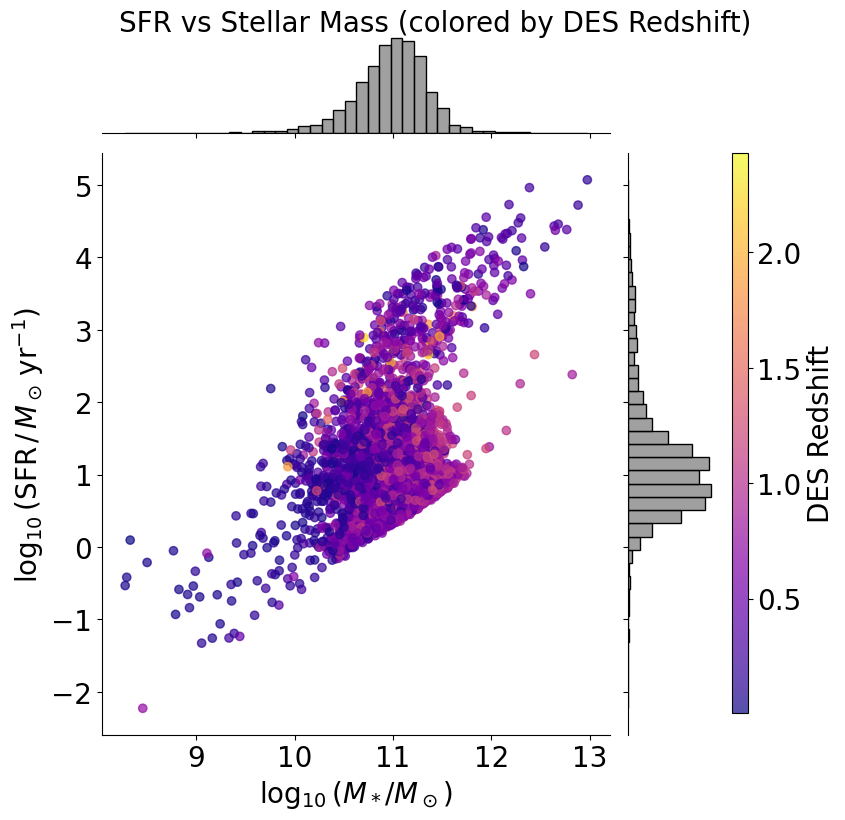

In [25]:
# Create the JointGrid
g = sns.JointGrid(
    data=catalog_pd,
    x='log_stellar_mass',
    y='log_sfr',
    height=8
)

# Main scatterplot with color by redshift
points = g.ax_joint.scatter(
    catalog_pd['log_stellar_mass'],
    catalog_pd['log_sfr'],
    c=catalog_pd['DESY6_dnf_z'],
    cmap='plasma',
    alpha=0.7
)

# Add marginal histograms
sns.histplot(
    data=catalog_pd,
    x='log_stellar_mass',
    bins=40,
    ax=g.ax_marg_x,
    color='grey',
    edgecolor='black'
)
sns.histplot(
    data=catalog_pd,
    y='log_sfr',
    bins=40,
    ax=g.ax_marg_y,
    color='grey',
    edgecolor='black'
)

# Set axis labels and title with larger font
g.set_axis_labels(
    r'$\log_{10}(M_*/M_\odot)$',
    r'$\log_{10}({\rm SFR}\,/\,M_\odot\,{\rm yr}^{-1})$',
    fontsize=20
)
g.ax_joint.tick_params(axis='both', labelsize=20)
g.ax_marg_x.tick_params(labelsize=20)
g.ax_marg_y.tick_params(labelsize=20)

# Title
g.fig.suptitle('SFR vs Stellar Mass (colored by DES Redshift)', fontsize=20)
g.fig.subplots_adjust(top=0.95, right=0.85)  # Shrink plot area to make room for colorbar

# Add external colorbar with larger label and ticks
cbar_ax = g.fig.add_axes([0.87, 0.1, 0.02, 0.7])
cbar = g.fig.colorbar(points, cax=cbar_ax)
cbar.set_label('DES Redshift', fontsize=20)
cbar.ax.tick_params(labelsize=20)

plt.show()

## Grid of Plots

In [15]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# properties = ['log_stellar_mass', 'log_sfr_permass', 'log_metallicity', 'log_age', 'log_Av_BC', 'bayes.agn.fracAGN']
# plot_df = catalog_pd[properties + ['bayes.universe.redshift']].dropna()

# norm = plt.Normalize(plot_df['bayes.universe.redshift'].min(), plot_df['bayes.universe.redshift'].max())
# cmap = plt.cm.plasma
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

# n = len(properties)
# fig, axes = plt.subplots(n, n, figsize=(16, 16), constrained_layout=False)

# # Adjust the subplot area to leave space for colorbar on the right
# plt.subplots_adjust(right=0.9, top=0.95, bottom=0.1, left=0.1, wspace=0.1, hspace=0.1)

# for i in range(n):
#     for j in range(n):
#         ax = axes[i, j]
#         if i == j:
#             sns.histplot(plot_df[properties[i]], bins=30, color='grey', ax=ax)
#         else:
#             xdata = plot_df[properties[j]]
#             ydata = plot_df[properties[i]]
#             sc = ax.scatter(
#                 xdata, ydata,
#                 c=plot_df['bayes.universe.redshift'],
#                 cmap=cmap,
#                 norm=norm,
#                 s=10,
#                 alpha=0.6
#             )
#             xpad = (xdata.max() - xdata.min()) * 0.05
#             ypad = (ydata.max() - ydata.min()) * 0.05
#             ax.set_xlim(xdata.min() - xpad, xdata.max() + xpad)
#             ax.set_ylim(ydata.min() - ypad, ydata.max() + ypad)

#         if i == n - 1:
#             ax.set_xlabel(properties[j], fontsize=8, rotation=45)
#         else:
#             ax.set_xticks([])
#         if j == 0:
#             ax.set_ylabel(properties[i], fontsize=8)
#         else:
#             ax.set_yticks([])

# # Create colorbar axes on the right outside the plot area
# cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])  # [left, bottom, width, height]
# cbar = fig.colorbar(sm, cax=cbar_ax)
# cbar.set_label('Redshift')

# plt.suptitle('6×6 Property Grid Colored by Redshift', fontsize=16)
# plt.show()


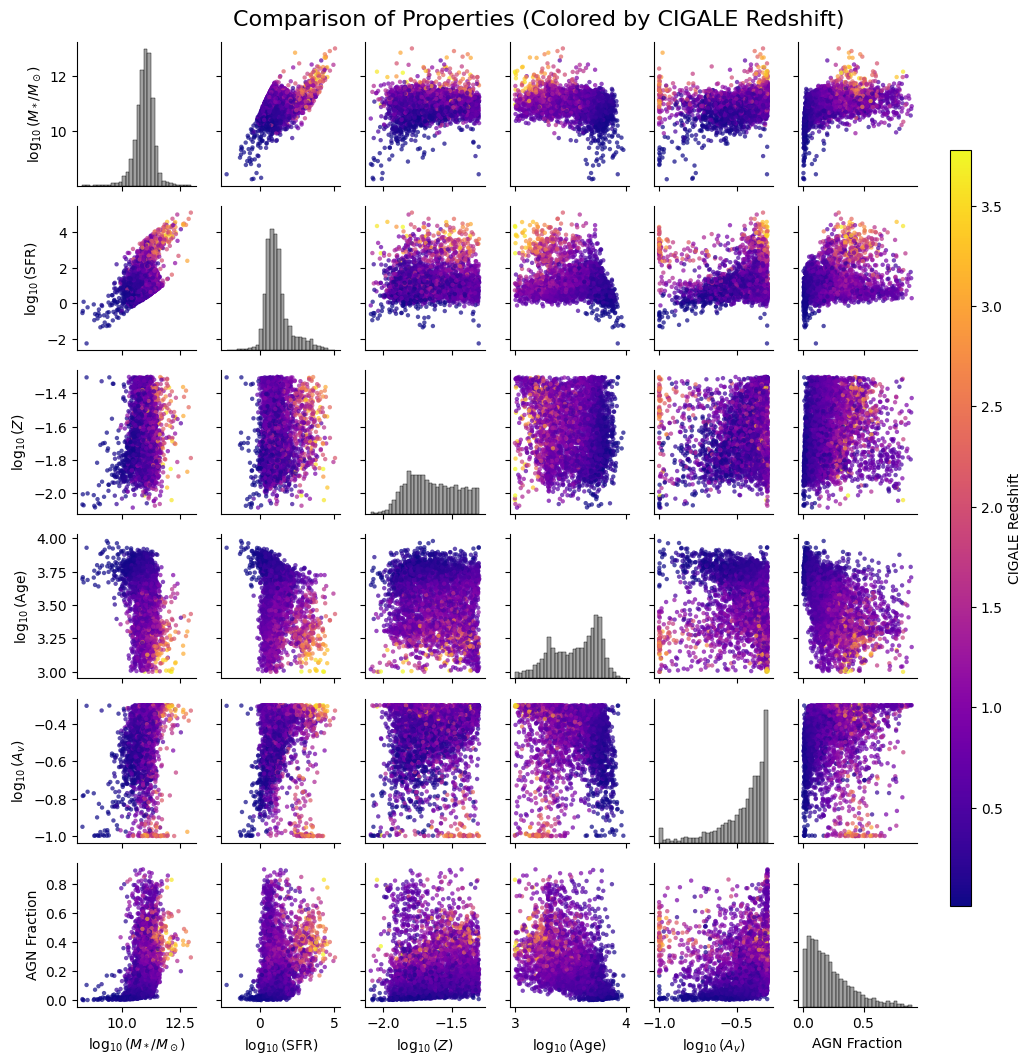

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

properties = ['log_stellar_mass', 'log_sfr', 'log_metallicity', 'log_age', 'log_Av_BC', 'bayes.agn.fracAGN']

labels = {
    'log_stellar_mass': r'$\log_{10}(M_*/M_\odot)$',
    'log_sfr': r'$\log_{10}(\mathrm{SFR})$',
    'log_metallicity': r'$\log_{10}(Z)$',
    'log_age': r'$\log_{10}(\mathrm{Age})$',
    'log_Av_BC': r'$\log_{10}(A_v)$',
    'bayes.agn.fracAGN': r'AGN Fraction'
}

plot_df = catalog_pd[properties]

# Create PairGrid
g = sns.PairGrid(
    data=plot_df,
    vars=properties,
    height=1.8,
    aspect=1
)

# Diagonal: histograms
g.map_diag(sns.histplot, color='grey', bins=30)

# Off-diagonal: scatter plots with continuous redshift coloring
g.map_offdiag(
    sns.scatterplot,
    hue=catalog_pd['bayes.universe.redshift'],
    palette='plasma',
    alpha=0.7,
    s=10,
    linewidth=0
)

# Create colorbar
norm = Normalize(
    vmin=catalog_pd['bayes.universe.redshift'].min(),
    vmax=catalog_pd['bayes.universe.redshift'].max()
)
sm = ScalarMappable(norm=norm, cmap='plasma')
sm.set_array([])

# Adjust subplot layout to make space for colorbar
plt.subplots_adjust(right=0.85)  # Increase right margin

# Add colorbar to a specific axis (far right)
cbar_ax = g.fig.add_axes([0.88, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = g.fig.colorbar(
    sm,
    cax=cbar_ax,
    label='CIGALE Redshift'
)

# Set custom axis labels
for ax, var in zip(g.axes[-1, :], properties):
    ax.set_xlabel(labels[var], fontsize=10)
for ax, var in zip(g.axes[:, 0], properties):
    ax.set_ylabel(labels[var], fontsize=10)

plt.subplots_adjust(top=0.95)
g.fig.suptitle('Comparison of Properties (Colored by CIGALE Redshift)', fontsize=16)

plt.show()

# Comparison between Star Formation Rate and Radio Emission